In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
from keras.layers import Dense, Dropout
from keras.models import Sequential
from numpy import random as npr
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier, plot_tree

print("XGBoost version:", xgboost.__version__)

np.random.seed(69420)


XGBoost version: 1.7.4


## Creating a dataset
We created a dataset which features a sine wave, a square and a circle to classify.

In [81]:
def classify(a, b):
    r = 0
    if (
        b > 1.2 * a
        or b < a
        or (a - 2) ** 2 + (b - 8) ** 2 < 1
        or b < -(a - 6) * (a - 10)
    ):
        r = 1
    elif (
        (b < 1.2 * a and b > a)
        or (a - 2) ** 2 + (b - 8) ** 2 < 4
        or b < -(a - 5) * (a - 11)
    ):
        r = 0
    return int(r)


N = 3000
X = 10 * npr.rand(N, 2)
y = np.zeros(N)
for i in range(N):
    y[i] = classify(X[i, 0], X[i, 1])


Text(0.5, 1.0, 'Data')

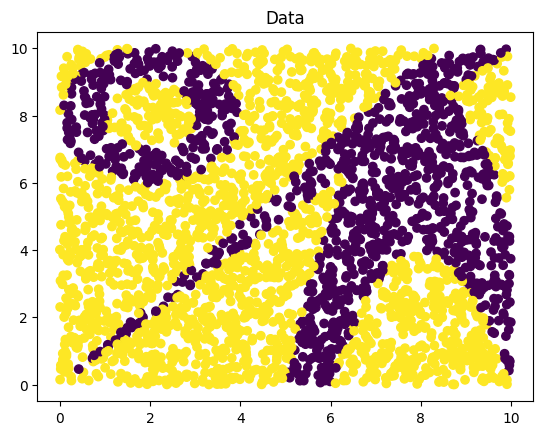

In [83]:
fig, AX = plt.subplots()

AX.scatter(X[:, 0], X[:, 1], c=y)
AX.set_title("Data")


In [84]:
permutation = np.random.permutation(X.shape[0])

train_percentage = 0.8
tsize = int(train_percentage * N)

X = X[permutation]
y = y[permutation]

X_train, X_valid = X[:tsize], X[tsize:]
y_train, y_valid = y[:tsize], y[tsize:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)


Labels in training dataset:  [0. 1.]
Frequencies in training dataset:  [ 911 1489]


## DNN
We'll use as a starting point the model we optimized in the first laboratory exercise.

In [71]:
model = Sequential()
model.add(Dense(20, input_shape=(2,), activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.01))
model.add(Dense(1, activation="sigmoid"))
nepoch = 500

print(model.summary())

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                60        
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,341
Trainable params: 1,341
Non-traina

In [72]:
fit = model.fit(
    X_train,
    y_train,
    epochs=nepoch,
    batch_size=50,
    validation_data=(X_valid, y_valid),
    verbose=False,
)


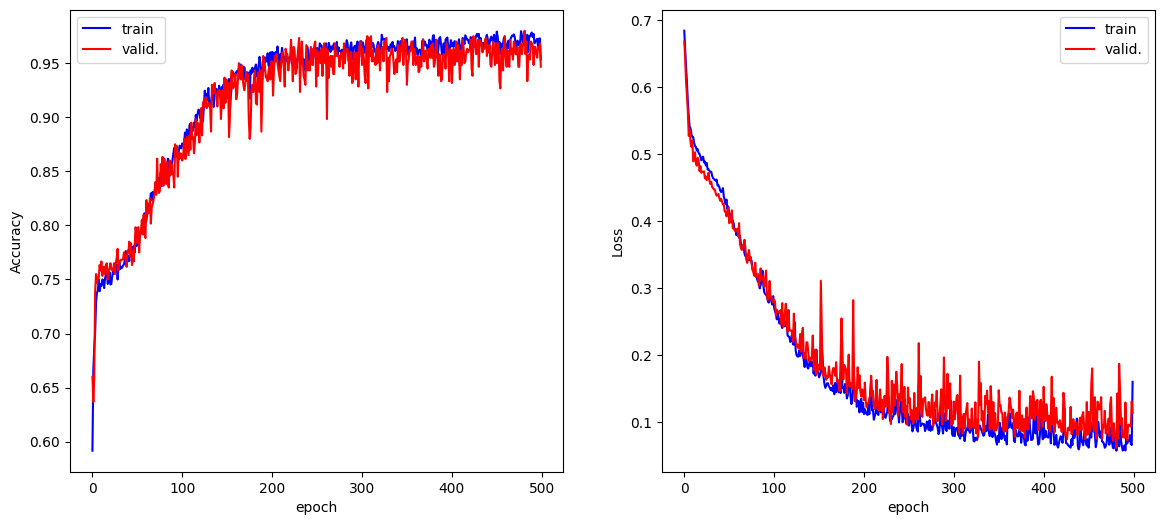

In [73]:
fig, AX = plt.subplots(1, 2, figsize=(14, 6.0))
ax = AX[0]
ax.plot(fit.history["accuracy"], label="Training", c="b")
ax.plot(fit.history["val_accuracy"], label="Validation", c="r")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
ax = AX[1]
ax.plot(fit.history["loss"], label="Training", c="b")
ax.plot(fit.history["val_loss"], label="Validation", c="r")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()


In [74]:
v = np.linspace(0, 10, 1000)
grid = 10 * npr.rand(N, 2)
# grid = np.reshape(np.meshgrid(v,v), (1000,1000,2))
pred = model.predict(grid)


94/94 [==============================] - 0s 1ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

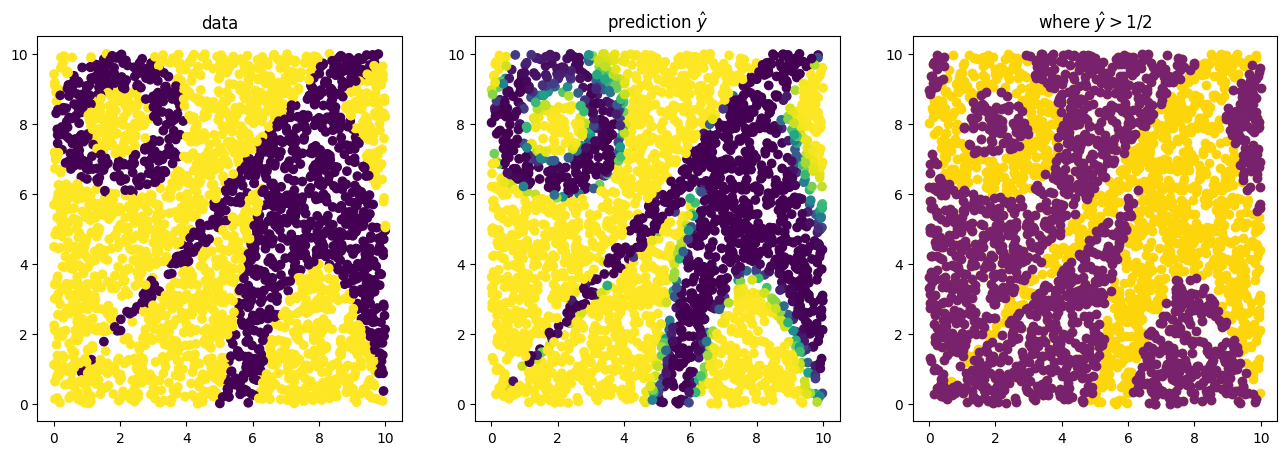

In [75]:
fig, AX = plt.subplots(1, 3, figsize=(16, 5.0))
ax = AX[0]
ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set_title("Data")
ax = AX[1]
ax.scatter(grid[:, 0], grid[:, 1], c=pred)
ax.set_title("Prediction $\\hat y$")
ax = AX[2]
W1 = np.where(pred > 0.5)[0]
ax.scatter(grid[:, 0], grid[:, 1], c="#FDD50B")
ax.scatter(grid[W1, 0], grid[W1, 1], c="#78226D")
ax.set_title("Where $\\hat y > 1/2$")
plt.show
plt.show


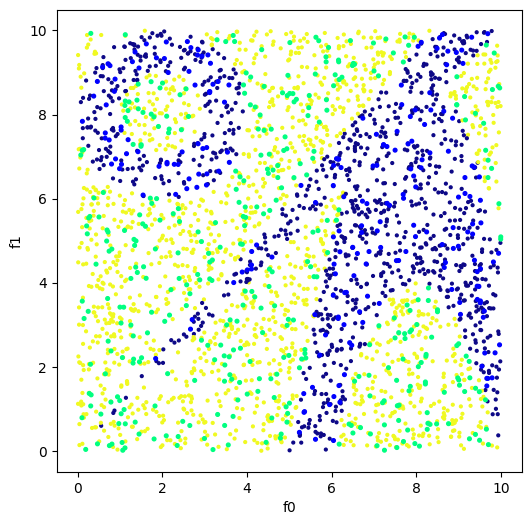

In [76]:
def scat(x, y, s=4, cmap="plasma"):
    plt.scatter(x[:, 0], x[:, 1], s=s, c=y, cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")


plt.figure(figsize=(6, 6))
scat(X_train, y_train)
scat(X_valid, y_valid, cmap="winter", s=7)
plt.show()


In [85]:
def classifyx(clf=GradientBoostingClassifier(), show=False):
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_valid)

    print(
        "errors: {:.2f}%".format(100 * (1 - clf.score(X_valid, y_valid)))
    )

    dx = 0.02
    x_seq = np.arange(0, 10 + dx, dx)
    nx = len(x_seq)
    x_plot = np.zeros((nx * nx, 2))
    q = 0
    for i in range(nx):
        for j in range(nx):
            x_plot[q, :] = [x_seq[i], x_seq[j]]
            q += 1
    y_plot = clf.predict(x_plot)

    plt.figure(figsize=(6, 6))
    plt.title(str(clf))
    scat(x_plot, y_plot, cmap="winter", s=1)
    scat(X_train, y_train, s=7)
    plt.show()

    if show:
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=", num_trees)

        fig, AX = plt.subplots(3, 1, figsize=(30, 30))
        for i in range(min(3, num_trees)):
            ax = AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)
        plt.show()


errors: 7.50%


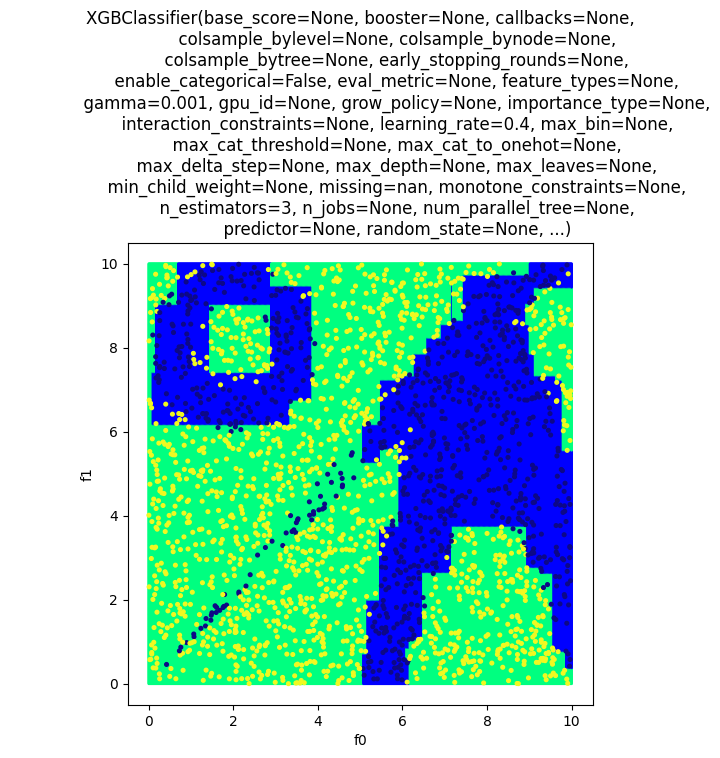

In [86]:
classifyx(
    XGBClassifier(
        seed=1,
        objective="binary:logistic",
        learning_rate=0.4,
        gamma=0.001,
        reg_lambda=0.001,
        n_estimators=3,
    ),
    show=False,
)


# Varying number of samples

In [ ]:
Ns = [i for i in range(0, N + 1, N // 10)][1:]
nn_err = []
xgb_err = []
for i in Ns:
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    print(i)
    X0 = X[:i]
    y0 = y[:i]

    K = 5
    vsize = int(i / K)
    nn_vals = []
    xgb_vals = []

    for k in range(K):
        try:
            X_train = np.concatenate(
                (X0[(k + 1) * vsize :], X0[: k * vsize])
            )
            y_train = np.concatenate(
                (y0[(k + 1) * vsize :], y0[: k * vsize])
            )
        except:
            if len(X0[: k * vsize]) == 0:
                X_train = X0[(k + 1) * vsize :]
            elif len(X0[(k + 1) * vsize :]) == 0:
                X_train = X0[: k * vsize]
            else:
                print(X0[: k * vsize], X0[(k + 1) * vsize])
                raise

        X_valid = X0[k * vsize : (k + 1) * vsize]
        y_valid = y0[k * vsize : (k + 1) * vsize]

        model = Sequential()
        model.add(Dense(20, input_shape=(2,), activation="relu"))
        model.add(Dense(20, activation="relu"))
        model.add(Dense(20, activation="relu"))
        model.add(Dense(20, activation="relu"))
        model.add(Dropout(0.01))
        model.add(Dense(1, activation="sigmoid"))
        nepoch = 500

        model.compile(
            loss="binary_crossentropy",
            # optimizer='RMSprop',
            optimizer="adam",
            metrics=["accuracy"],
        )
        fit = model.fit(
            X_train,
            y_train,
            epochs=nepoch,
            batch_size=50,
            validation_data=(X_valid, y_valid),
            verbose=0,
        )
        nn_vals.append(1 - fit.history["val_accuracy"][-1])

        clf = XGBClassifier(
            seed=1,
            objective="binary:logistic",
            # objective="reg:squarederror",eval_metric="rmse",
            learning_rate=0.4,
            gamma=1,
            reg_lambda=0.001,
            n_estimators=3,
        )
        clf.fit(X_train, y_train)

        xgb_vals.append(1 - clf.score(X_valid, y_valid))

    nn_err.append((np.mean(nn_vals), np.std(nn_vals)))
    xgb_err.append((np.mean(xgb_vals), np.std(xgb_vals)))


In [ ]:
plt.plot(Ns, [i[0] for i in nn_err], color="red", label="NN")
plt.fill_between(
    Ns,
    [i[0] for i in nn_err] + np.array([i[1] for i in nn_err]),
    [i[0] for i in nn_err] - np.array([i[1] for i in nn_err]),
    facecolor="red",
    alpha=0.3,
)
plt.plot(Ns, [i[0] for i in xgb_err], color="navy", label="XGBoost")
plt.fill_between(
    Ns,
    [i[0] for i in xgb_err] + np.array([i[1] for i in xgb_err]),
    [i[0] for i in xgb_err] - np.array([i[1] for i in xgb_err]),
    facecolor="navy",
    alpha=0.3,
)
plt.xlabel("Training samples")
plt.ylabel("Validation error")


Fitting 4 folds for each of 90 candidates, totalling 360 fits
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Fitting 4 folds for each of 90 candidates, totalling 360 fits


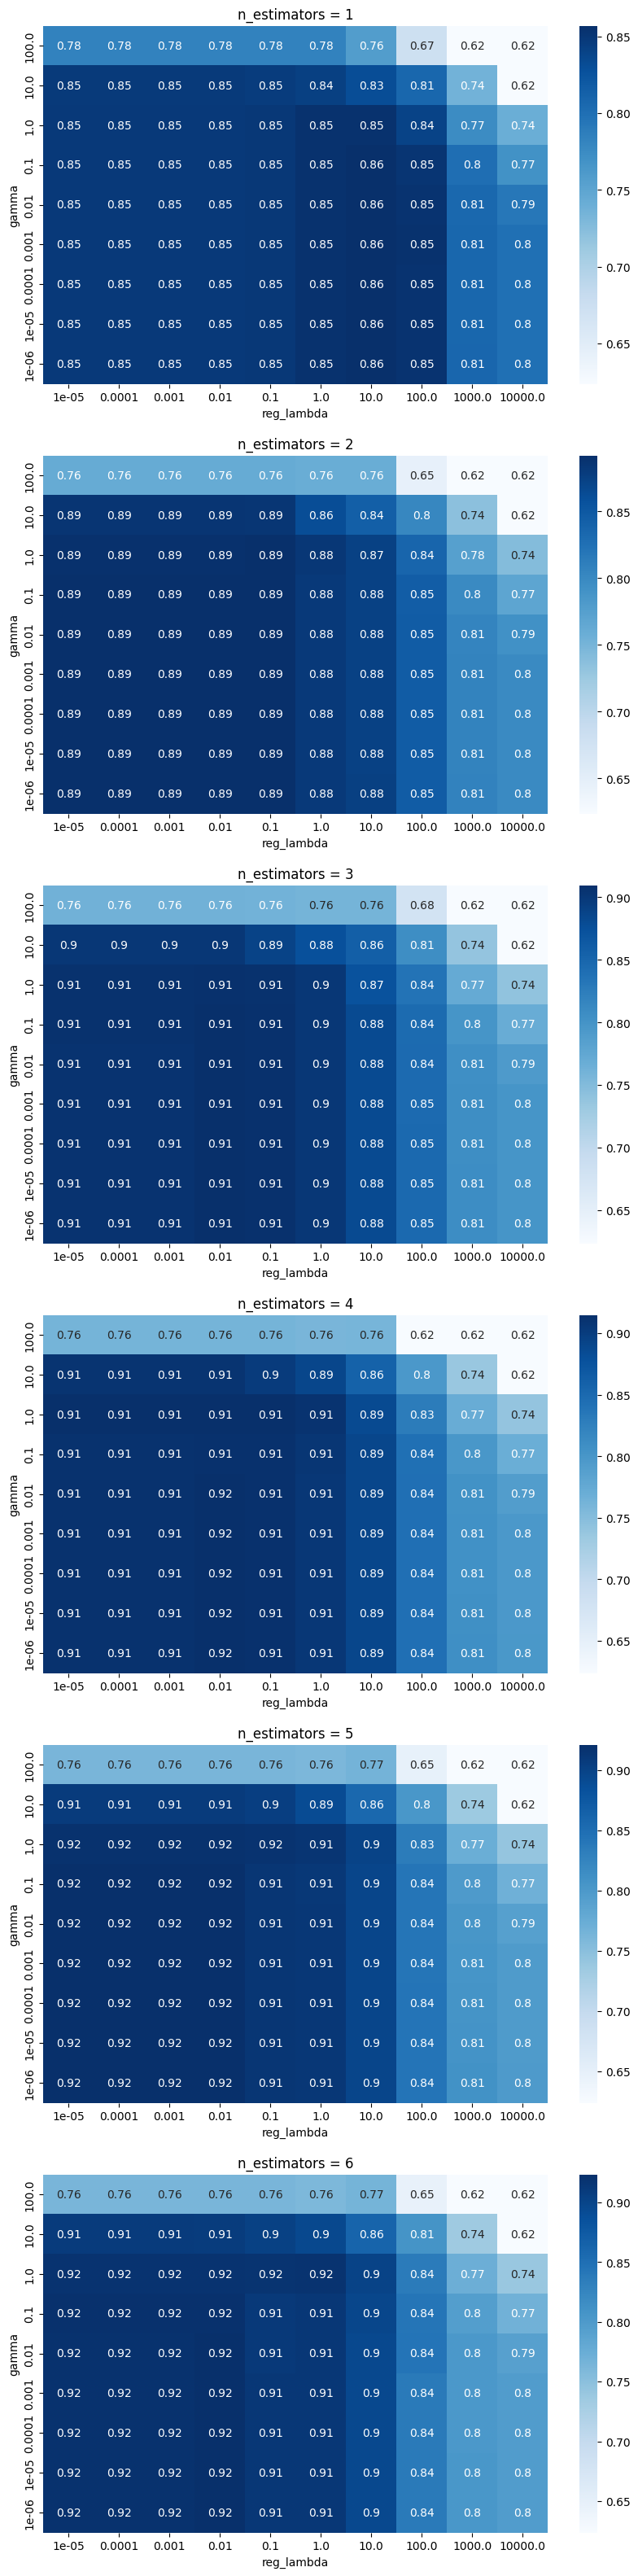

In [100]:
fig, ax = plt.subplots(nrows=6, figsize=(10, 40))


for n_est in range(1, 7):
    parameters = {
        "gamma": [10**i for i in reversed(range(-6, 3))],
        "reg_lambda": [10 ** (-i) for i in reversed(range(-4, 6))],
    }

    clf = XGBClassifier(
        seed=1,
        objective="binary:logistic",
        learning_rate=0.4,
        n_estimators=n_est,
    )

    grid_search = GridSearchCV(
        estimator=clf, param_grid=parameters, cv=4, verbose=True
    )
    grid_search.fit(X, y)

    df = pd.DataFrame(
        grid_search.cv_results_["mean_test_score"].reshape(
            len(parameters["gamma"]), len(parameters["reg_lambda"])
        ),
        index=parameters["gamma"],
        columns=parameters["reg_lambda"],
    )

    sns.heatmap(df, annot=True, cmap="Blues", ax=ax[n_est - 1])
    ax[n_est - 1].set_title(f"n_estimators = {n_est}")
    ax[n_est - 1].set_xlabel("reg_lambda")
    ax[n_est - 1].set_ylabel("gamma")


The XGBoost model appears to be quite robust with respect to changes in the main parameters, having very similar performances for all $\gamma<1, \lambda<1$ when using 3 or more estimators. The biggest variation in labelling is found along the thin diagonal line, since the models might choose to misclassify it in order to keep a simpler tree structure, due to the small amount of points involved.

Anyhow, we emphasize that a 2D binary classification task represents a best-case scenario for the XGBoost algorithm, and its true limits would probably manifest in higher-dimensional and/or multi-class tasks.
We also noticed a very strong increase in training speed with respect to the neural network.

errors: 7.50%


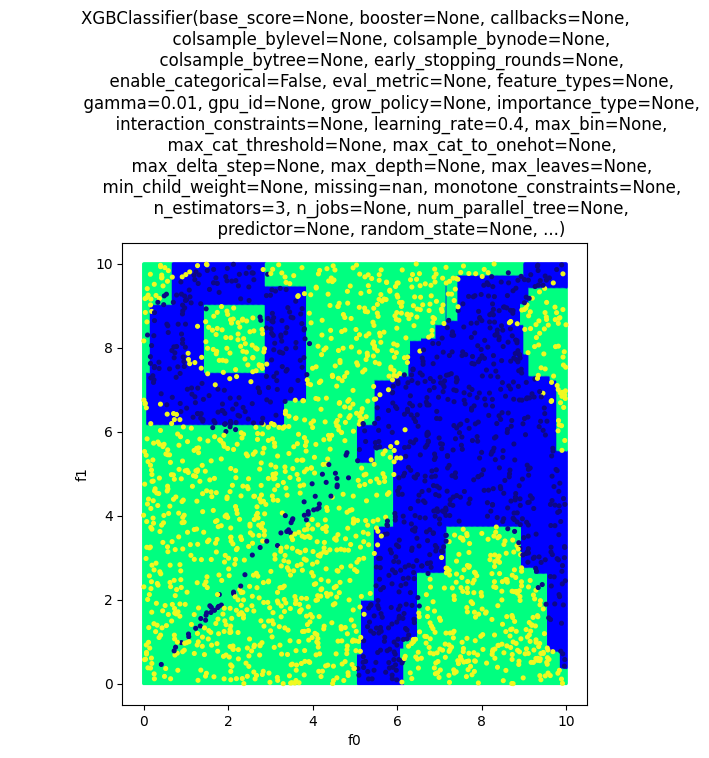

In [101]:
classifyx(
    XGBClassifier(
        seed=1,
        objective="binary:logistic",
        # objective="reg:squarederror",eval_metric="rmse",
        learning_rate=0.4,
        gamma=0.01,
        reg_lambda=0.01,
        n_estimators=3,
    ),
    show=False,
)
